In [ ]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
!git clone https://huggingface.co/datasets/imdb

Cloning into 'imdb'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (63/63), 14.79 KiB | 630.00 KiB/s, done.
Filtering content: 100% (3/3), 79.58 MiB | 12.25 MiB/s, done.


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
import random

# Download NLTK resources
nltk.download('punkt')

# Load the IMDB dataset
# Load the IMDb dataset
dataset = load_dataset("imdb")




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Epoch 1/10, Train Loss: 0.6992, Train Acc: 0.5023, Test Loss: 0.6942, Test Acc: 0.4958
Epoch 2/10, Train Loss: 0.6915, Train Acc: 0.5130, Test Loss: 0.6954, Test Acc: 0.4952
Epoch 3/10, Train Loss: 0.6846, Train Acc: 0.5251, Test Loss: 0.6985, Test Acc: 0.5090
Epoch 4/10, Train Loss: 0.6720, Train Acc: 0.5305, Test Loss: 0.7122, Test Acc: 0.4976
Epoch 5/10, Train Loss: 0.6634, Train Acc: 0.5393, Test Loss: 0.7116, Test Acc: 0.5088
Epoch 6/10, Train Loss: 0.6482, Train Acc: 0.5464, Test Loss: 0.7498, Test Acc: 0.4954
Epoch 7/10, Train Loss: 0.6322, Train Acc: 0.5528, Test Loss: 0.7559, Test Acc: 0.4952
Epoch 8/10, Train Loss: 0.6239, Train Acc: 0.5569, Test Loss: 0.7864, Test Acc: 0.4950
Epoch 9/10, Train Loss: 0.6168, Train Acc: 0.5582, Test Loss: 0.8093, Test Acc: 0.5046
Epoch 10/10, Train Loss: 0.6148, Train Acc: 0.5618, Test Loss: 0.8129, Test Acc: 0.5084


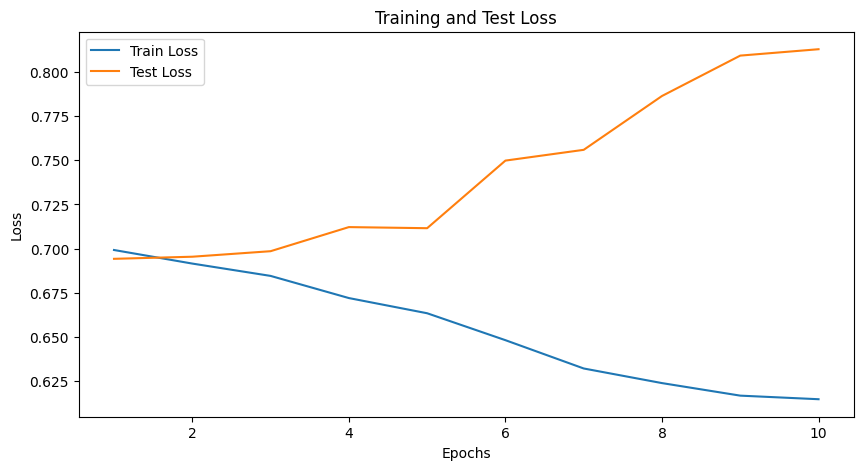

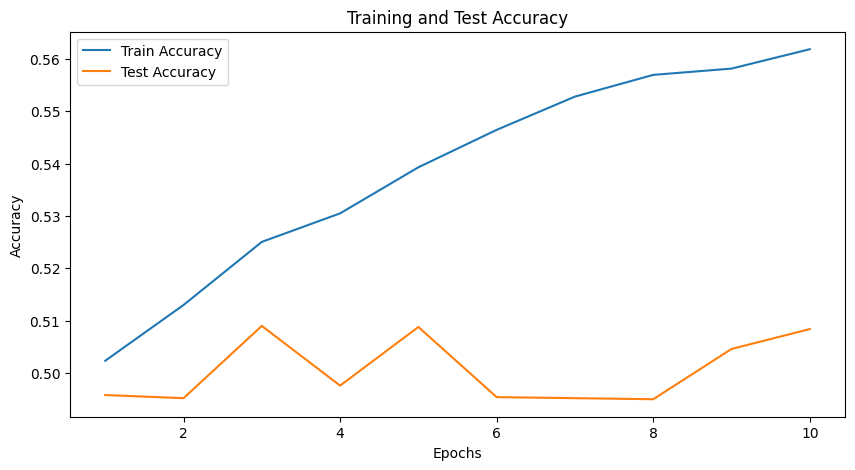

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Step 1: Prepare the Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_index, max_length):
        self.reviews = reviews
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize and convert words to indices
        review_indices = [self.word_to_index[word] if word in self.word_to_index else 0 for word in review]
        # Pad or truncate the review to the max_length
        review_indices = review_indices[:self.max_length] + [0] * (self.max_length - len(review_indices))

        return torch.tensor(review_indices), torch.tensor(label)

def preprocess_text(reviews, use_stemming=False):
    if use_stemming:
        stemmer = PorterStemmer()
        preprocessed_reviews = [[stemmer.stem(token) for token in word_tokenize(review.lower())] for review in reviews]
    else:
        lemmatizer = WordNetLemmatizer()
        preprocessed_reviews = [[lemmatizer.lemmatize(token) for token in word_tokenize(review.lower())] for review in reviews]
    return preprocessed_reviews

def create_word_to_index(reviews):
    word_to_index = {}
    index = 1  # Start index from # Start index from 1, reserve index 0 for padding
    for review in reviews:
        for word in review:
            if word not in word_to_index:
                word_to_index[word] = index
                index += 1
    return word_to_index

# Step 2: Create Dataloaders

def create_dataloaders(reviews, labels, word_to_index, max_length, batch_size, split_ratio=0.2):
    dataset = IMDBDataset(reviews, labels, word_to_index, max_length)
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = int(split_ratio * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Step 3: Define the RNN Model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_strategy='last_output'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_strategy = rnn_strategy

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)

        if self.rnn_strategy == 'last_output':
            output = output[:, -1, :]  # Use the last output of the RNN layer
        elif self.rnn_strategy == 'mean_of_all_outputs':
            output = output.mean(dim=1)  # Use the mean of all outputs of the RNN layer

        output = self.fc(output)
        return output

# Step 4: Training and Testing Functions

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Step 5: Hyperparameters and Training Loop

def train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb=False):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
        test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            })

    return train_losses, train_accuracies, test_losses, test_accuracies

# Step 6: Main Function

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels

def main():
    reviews, labels = load_imdb_dataset()
    # Define hyperparameters
    max_vocab_size = 10000  # Maximum vocabulary size
    hidden_size = 128
    output_size = 2  # Binary classification: positive or negative
    max_length = 500
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    # Preprocess and tokenize reviews
    reviews = preprocess_text(reviews)
    flat_reviews = [word for review in reviews for word in review]
    word_freq = nltk.FreqDist(flat_reviews)
    # Select the most common words up to the maximum vocabulary size
    vocab = {word for word, _ in word_freq.most_common(max_vocab_size)}
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve index 0 for padding

    # Create DataLoader
    train_loader, test_loader = create_dataloaders(reviews, labels, word_to_index, max_length, batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNModel(input_size=len(word_to_index) + 1, hidden_size=hidden_size, output_size=output_size).to(device)  # Add 1 for padding index
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize Weights & Biases if enabled
    use_wandb = True  # Set to True to enable logging with wandb
    if use_wandb:
        wandb.init(project="imdb_review_sentiment_classification", config={
            "max_vocab_size": max_vocab_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "max_length": max_length,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "use_stemming": True,  # Change to False if not using stemming
            "rnn_strategy": 'last_output'  # Change to 'mean_of_all_outputs' to test different strategy
        })
        wandb.watch(model)

    # Training loop
    train_losses, train_accuracies, test_losses, test_accuracies = train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb)

    # Plot loss and accuracy graphs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/10, Train Loss: 0.6994, Train Acc: 0.4991, Test Loss: 0.6949, Test Acc: 0.5012
Epoch 2/10, Train Loss: 0.6909, Train Acc: 0.5123, Test Loss: 0.6983, Test Acc: 0.5012
Epoch 3/10, Train Loss: 0.6856, Train Acc: 0.5201, Test Loss: 0.7006, Test Acc: 0.5012
Epoch 4/10, Train Loss: 0.6760, Train Acc: 0.5276, Test Loss: 0.7159, Test Acc: 0.5052
Epoch 5/10, Train Loss: 0.6612, Train Acc: 0.5433, Test Loss: 0.7202, Test Acc: 0.5038
Epoch 6/10, Train Loss: 0.6548, Train Acc: 0.5418, Test Loss: 0.7448, Test Acc: 0.5002
Epoch 7/10, Train Loss: 0.6348, Train Acc: 0.5555, Test Loss: 0.7620, Test Acc: 0.5050
Epoch 8/10, Train Loss: 0.6248, Train Acc: 0.5599, Test Loss: 0.7858, Test Acc: 0.5016
Epoch 9/10, Train Loss: 0.6169, Train Acc: 0.5613, Test Loss: 0.8032, Test Acc: 0.5042
Epoch 10/10, Train Loss: 0.6155, Train Acc: 0.5595, Test Loss: 0.8212, Test Acc: 0.5076


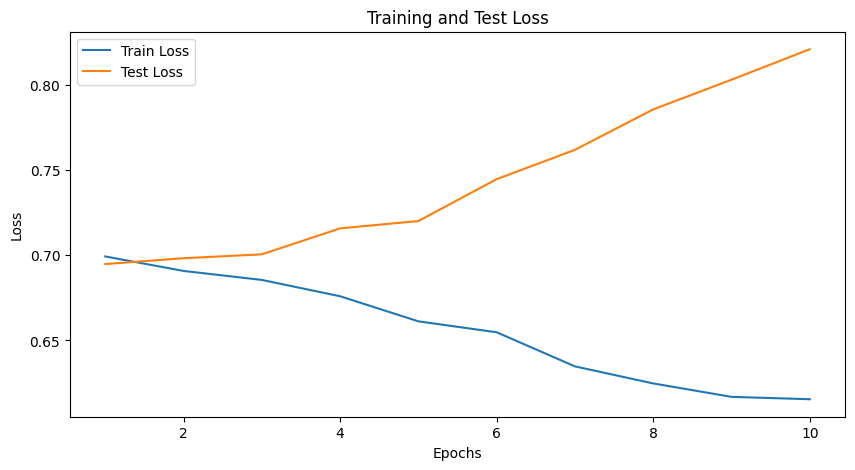

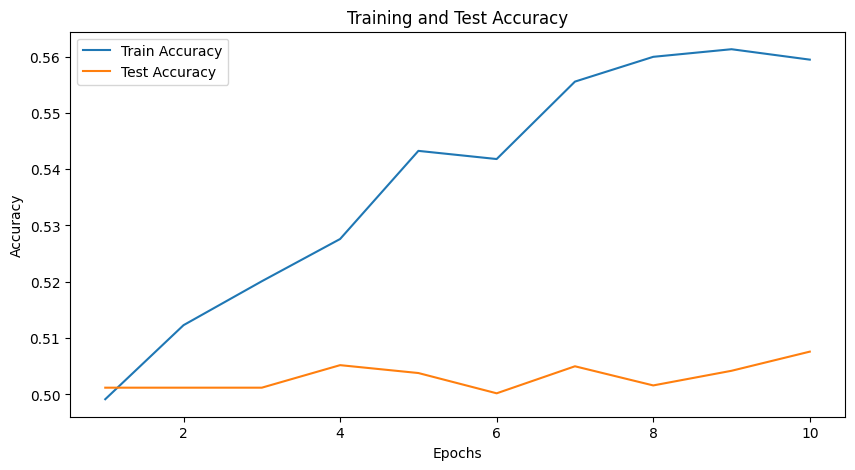

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Step 1: Prepare the Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_index, max_length):
        self.reviews = reviews
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize and convert words to indices
        review_indices = [self.word_to_index[word] if word in self.word_to_index else 0 for word in review]
        # Pad or truncate the review to the max_length
        review_indices = review_indices[:self.max_length] + [0] * (self.max_length - len(review_indices))

        return torch.tensor(review_indices), torch.tensor(label)

def preprocess_text(reviews, use_stemming=False):
    if use_stemming:
        stemmer = PorterStemmer()
        preprocessed_reviews = [[stemmer.stem(token) for token in word_tokenize(review.lower())] for review in reviews]
    else:
        lemmatizer = WordNetLemmatizer()
        preprocessed_reviews = [[lemmatizer.lemmatize(token) for token in word_tokenize(review.lower())] for review in reviews]
    return preprocessed_reviews

def create_word_to_index(reviews):
    word_to_index = {}
    index = 1  # Start index from # Start index from 1, reserve index 0 for padding
    for review in reviews:
        for word in review:
            if word not in word_to_index:
                word_to_index[word] = index
                index += 1
    return word_to_index

# Step 2: Create Dataloaders

def create_dataloaders(reviews, labels, word_to_index, max_length, batch_size, split_ratio=0.2):
    dataset = IMDBDataset(reviews, labels, word_to_index, max_length)
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = int(split_ratio * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Step 3: Define the RNN Model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_strategy='last_output'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_strategy = rnn_strategy

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)

        if self.rnn_strategy == 'last_output':
            output = output[:, -1, :]  # Use the last output of the RNN layer
        elif self.rnn_strategy == 'mean_of_all_outputs':
            output = output.mean(dim=1)  # Use the mean of all outputs of the RNN layer

        output = self.fc(output)
        return output

# Step 4: Training and Testing Functions

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Step 5: Hyperparameters and Training Loop

def train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb=False):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
        test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            })

    return train_losses, train_accuracies, test_losses, test_accuracies

# Step 6: Main Function

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels

def main():
    reviews, labels = load_imdb_dataset()
    # Define hyperparameters
    max_vocab_size = 10000  # Maximum vocabulary size
    hidden_size = 128
    output_size = 2  # Binary classification: positive or negative
    max_length = 500
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10
    use_stemming = True

    # Preprocess and tokenize reviews
    reviews = preprocess_text(reviews, use_stemming=use_stemming)
    flat_reviews = [word for review in reviews for word in review]
    word_freq = nltk.FreqDist(flat_reviews)
    # Select the most common words up to the maximum vocabulary size
    vocab = {word for word, _ in word_freq.most_common(max_vocab_size)}
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve index 0 for padding

    # Create DataLoader
    train_loader, test_loader = create_dataloaders(reviews, labels, word_to_index, max_length, batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNModel(input_size=len(word_to_index) + 1, hidden_size=hidden_size, output_size=output_size).to(device)  # Add 1 for padding index
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize Weights & Biases if enabled
    use_wandb = True  # Set to True to enable logging with wandb
    if use_wandb:
        wandb.init(project="imdb_review_sentiment_classification", config={
            "max_vocab_size": max_vocab_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "max_length": max_length,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "use_stemming": True,  # Change to False if not using stemming
            "rnn_strategy": 'last_output'  # Change to 'mean_of_all_outputs' to test different strategy
        })
        wandb.watch(model)

    # Training loop
    train_losses, train_accuracies, test_losses, test_accuracies = train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb)

    # Plot loss and accuracy graphs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,█▃▇▃█▁▂█▇▇
test_loss,▁▂▂▁▂▃▄▅▇█
train_accuracy,▁▃▅▃▅▆▇▇▇█
train_loss,█▇▇▇▆▄▃▂▁▁
epoch,10
test_accuracy,0.509
test_loss,0.80186
train_accuracy,0.55855
train_loss,0.61984


Epoch 1/10, Train Loss: 0.6996, Train Acc: 0.5013, Test Loss: 0.7007, Test Acc: 0.5046
Epoch 2/10, Train Loss: 0.6906, Train Acc: 0.5143, Test Loss: 0.6987, Test Acc: 0.5062
Epoch 3/10, Train Loss: 0.6838, Train Acc: 0.5202, Test Loss: 0.7041, Test Acc: 0.5054
Epoch 4/10, Train Loss: 0.6727, Train Acc: 0.5285, Test Loss: 0.7104, Test Acc: 0.5088
Epoch 5/10, Train Loss: 0.6582, Train Acc: 0.5400, Test Loss: 0.7273, Test Acc: 0.5048
Epoch 6/10, Train Loss: 0.6417, Train Acc: 0.5512, Test Loss: 0.7467, Test Acc: 0.5074
Epoch 7/10, Train Loss: 0.6313, Train Acc: 0.5593, Test Loss: 0.7629, Test Acc: 0.5038
Epoch 8/10, Train Loss: 0.6236, Train Acc: 0.5567, Test Loss: 0.7873, Test Acc: 0.5098
Epoch 9/10, Train Loss: 0.6191, Train Acc: 0.5605, Test Loss: 0.7996, Test Acc: 0.5128
Epoch 10/10, Train Loss: 0.6156, Train Acc: 0.5638, Test Loss: 0.8079, Test Acc: 0.5114


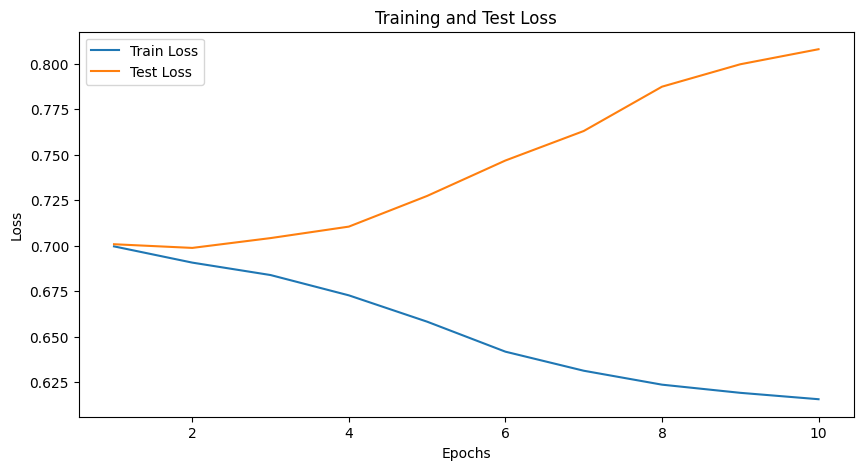

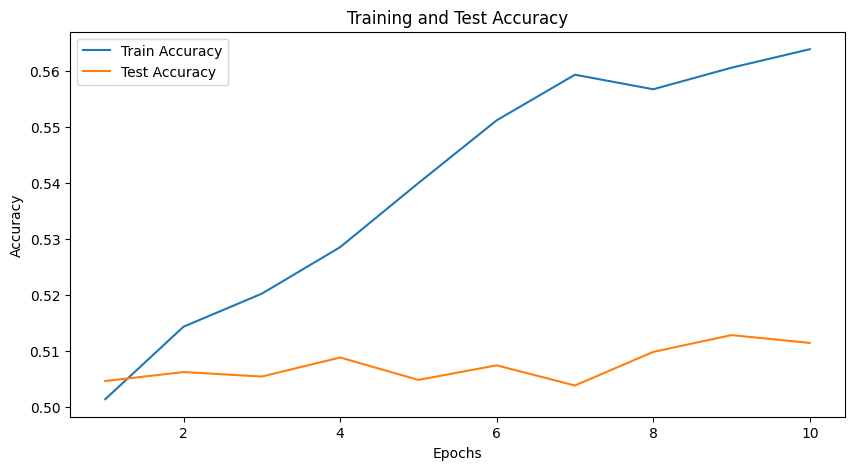

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Step 1: Prepare the Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_index, max_length):
        self.reviews = reviews
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize and convert words to indices
        review_indices = [self.word_to_index[word] if word in self.word_to_index else 0 for word in review]
        # Pad or truncate the review to the max_length
        review_indices = review_indices[:self.max_length] + [0] * (self.max_length - len(review_indices))

        return torch.tensor(review_indices), torch.tensor(label)

def preprocess_text(reviews, use_stemming=False):
    if use_stemming:
        stemmer = PorterStemmer()
        preprocessed_reviews = [[stemmer.stem(token) for token in word_tokenize(review.lower())] for review in reviews]
    else:
        lemmatizer = WordNetLemmatizer()
        preprocessed_reviews = [[lemmatizer.lemmatize(token) for token in word_tokenize(review.lower())] for review in reviews]
    return preprocessed_reviews

def create_word_to_index(reviews):
    word_to_index = {}
    index = 1  # Start index from # Start index from 1, reserve index 0 for padding
    for review in reviews:
        for word in review:
            if word not in word_to_index:
                word_to_index[word] = index
                index += 1
    return word_to_index

# Step 2: Create Dataloaders

def create_dataloaders(reviews, labels, word_to_index, max_length, batch_size, split_ratio=0.2):
    dataset = IMDBDataset(reviews, labels, word_to_index, max_length)
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = int(split_ratio * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Step 3: Define the RNN Model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_strategy='last_output'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_strategy = rnn_strategy

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)

        if self.rnn_strategy == 'last_output':
            output = output[:, -1, :]  # Use the last output of the RNN layer
        elif self.rnn_strategy == 'mean_of_all_outputs':
            output = output.mean(dim=1)  # Use the mean of all outputs of the RNN layer

        output = self.fc(output)
        return output

# Step 4: Training and Testing Functions

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Step 5: Hyperparameters and Training Loop

def train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb=False):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
        test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            })

    return train_losses, train_accuracies, test_losses, test_accuracies

# Step 6: Main Function

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels

def main():
    reviews, labels = load_imdb_dataset()
    # Define hyperparameters
    max_vocab_size = 10000  # Maximum vocabulary size
    hidden_size = 128
    output_size = 2  # Binary classification: positive or negative
    max_length = 500
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10
    use_stemming = True

    # Preprocess and tokenize reviews
    reviews = preprocess_text(reviews, use_stemming=use_stemming)
    flat_reviews = [word for review in reviews for word in review]
    word_freq = nltk.FreqDist(flat_reviews)
    # Select the most common words up to the maximum vocabulary size
    vocab = {word for word, _ in word_freq.most_common(max_vocab_size)}
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve index 0 for padding

    # Create DataLoader
    train_loader, test_loader = create_dataloaders(reviews, labels, word_to_index, max_length, batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNModel(input_size=len(word_to_index) + 1, hidden_size=hidden_size, output_size=output_size).to(device)  # Add 1 for padding index
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize Weights & Biases if enabled
    use_wandb = True  # Set to True to enable logging with wandb
    if use_wandb:
        wandb.init(project="imdb_review_sentiment_classification", config={
            "max_vocab_size": max_vocab_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "max_length": max_length,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "use_stemming": True,  # Change to False if not using stemming
            "rnn_strategy": 'mean_of_all_outputs'  # Change to 'mean_of_all_outputs' to test different strategy
        })
        wandb.watch(model)

    # Training loop
    train_losses, train_accuracies, test_losses, test_accuracies = train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb)

    # Plot loss and accuracy graphs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▂▂▂▆▄▁▆▂▅█
test_loss,▁▁▁▂▂▄▅▆▇█
train_accuracy,▁▂▃▄▆▆▇███
train_loss,█▇▇▆▅▄▃▂▁▁
epoch,10
test_accuracy,0.5076
test_loss,0.82116
train_accuracy,0.55945
train_loss,0.61547


Epoch 1/10, Train Loss: 0.6990, Train Acc: 0.4958, Test Loss: 0.6949, Test Acc: 0.5100
Epoch 2/10, Train Loss: 0.6913, Train Acc: 0.5141, Test Loss: 0.7039, Test Acc: 0.5008
Epoch 3/10, Train Loss: 0.6838, Train Acc: 0.5300, Test Loss: 0.7064, Test Acc: 0.5092
Epoch 4/10, Train Loss: 0.6893, Train Acc: 0.5128, Test Loss: 0.7013, Test Acc: 0.4998
Epoch 5/10, Train Loss: 0.6738, Train Acc: 0.5338, Test Loss: 0.7105, Test Acc: 0.5110
Epoch 6/10, Train Loss: 0.6573, Train Acc: 0.5427, Test Loss: 0.7320, Test Acc: 0.4960
Epoch 7/10, Train Loss: 0.6448, Train Acc: 0.5508, Test Loss: 0.7468, Test Acc: 0.4972
Epoch 8/10, Train Loss: 0.6322, Train Acc: 0.5534, Test Loss: 0.7624, Test Acc: 0.5104
Epoch 9/10, Train Loss: 0.6229, Train Acc: 0.5527, Test Loss: 0.7863, Test Acc: 0.5096
Epoch 10/10, Train Loss: 0.6198, Train Acc: 0.5585, Test Loss: 0.8019, Test Acc: 0.5090


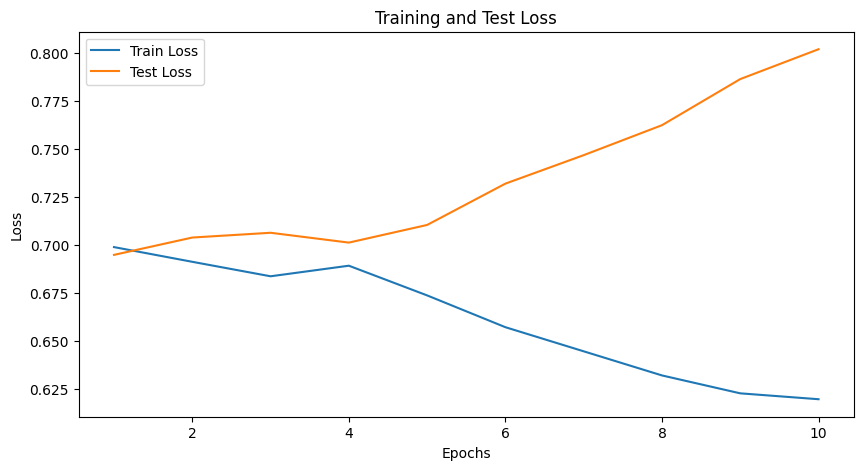

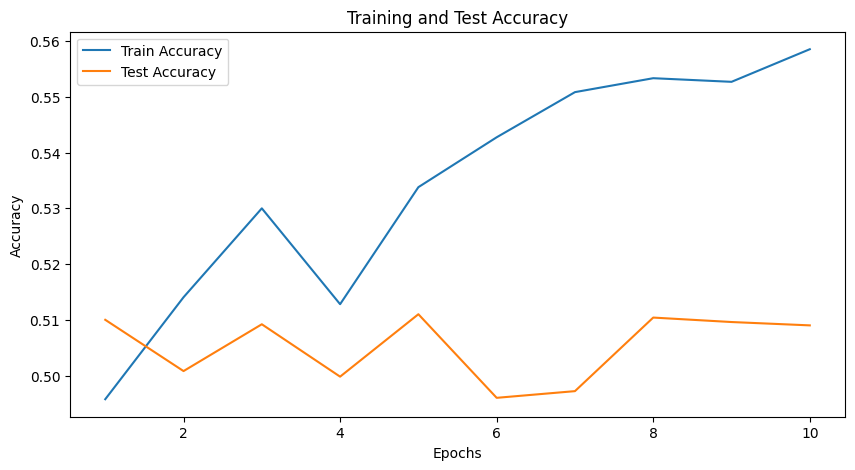

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Step 1: Prepare the Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_index, max_length):
        self.reviews = reviews
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize and convert words to indices
        review_indices = [self.word_to_index[word] if word in self.word_to_index else 0 for word in review]
        # Pad or truncate the review to the max_length
        review_indices = review_indices[:self.max_length] + [0] * (self.max_length - len(review_indices))

        return torch.tensor(review_indices), torch.tensor(label)

def preprocess_text(reviews, use_stemming=False):
    if use_stemming:
        stemmer = PorterStemmer()
        preprocessed_reviews = [[stemmer.stem(token) for token in word_tokenize(review.lower())] for review in reviews]
    else:
        lemmatizer = WordNetLemmatizer()
        preprocessed_reviews = [[lemmatizer.lemmatize(token) for token in word_tokenize(review.lower())] for review in reviews]
    return preprocessed_reviews

def create_word_to_index(reviews):
    word_to_index = {}
    index = 1  # Start index from # Start index from 1, reserve index 0 for padding
    for review in reviews:
        for word in review:
            if word not in word_to_index:
                word_to_index[word] = index
                index += 1
    return word_to_index

# Step 2: Create Dataloaders

def create_dataloaders(reviews, labels, word_to_index, max_length, batch_size, split_ratio=0.2):
    dataset = IMDBDataset(reviews, labels, word_to_index, max_length)
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = int(split_ratio * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Step 3: Define the RNN Model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_strategy='last_output'):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_strategy = rnn_strategy

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)

        if self.rnn_strategy == 'last_output':
            output = output[:, -1, :]  # Use the last output of the RNN layer
        elif self.rnn_strategy == 'mean_of_all_outputs':
            output = output.mean(dim=1)  # Use the mean of all outputs of the RNN layer

        output = self.fc(output)
        return output

# Step 4: Training and Testing Functions

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Step 5: Hyperparameters and Training Loop

def train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb=False):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
        test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            })

    return train_losses, train_accuracies, test_losses, test_accuracies

# Step 6: Main Function

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels

def main():
    reviews, labels = load_imdb_dataset()
    # Define hyperparameters
    max_vocab_size = 10000  # Maximum vocabulary size
    hidden_size = 128
    output_size = 2  # Binary classification: positive or negative
    max_length = 500
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    # Preprocess and tokenize reviews
    reviews = preprocess_text(reviews)
    flat_reviews = [word for review in reviews for word in review]
    word_freq = nltk.FreqDist(flat_reviews)
    # Select the most common words up to the maximum vocabulary size
    vocab = {word for word, _ in word_freq.most_common(max_vocab_size)}
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve index 0 for padding

    # Create DataLoader
    train_loader, test_loader = create_dataloaders(reviews, labels, word_to_index, max_length, batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNModel(input_size=len(word_to_index) + 1, hidden_size=hidden_size, output_size=output_size).to(device)  # Add 1 for padding index
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize Weights & Biases if enabled
    use_wandb = True  # Set to True to enable logging with wandb
    if use_wandb:
        wandb.init(project="imdb_review_sentiment_classification", config={
            "max_vocab_size": max_vocab_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "max_length": max_length,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "use_stemming": True,  # Change to False if not using stemming
            "rnn_strategy": 'mean_of_all_outputs'  # Change to 'mean_of_all_outputs' to test different strategy
        })
        wandb.watch(model)

    # Training loop
    train_losses, train_accuracies, test_losses, test_accuracies = train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb)

    # Plot loss and accuracy graphs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▂▃▂▅▂▄▁▆█▇
test_loss,▁▁▁▂▃▄▅▇▇█
train_accuracy,▁▂▃▄▅▇▇▇██
train_loss,█▇▇▆▅▃▂▂▁▁
epoch,10
test_accuracy,0.5114
test_loss,0.80785
train_accuracy,0.56385
train_loss,0.61562


Epoch 1/10, Train Loss: 0.6951, Train Acc: 0.4994, Test Loss: 0.6925, Test Acc: 0.5164
Epoch 2/10, Train Loss: 0.6902, Train Acc: 0.5115, Test Loss: 0.6931, Test Acc: 0.5140
Epoch 3/10, Train Loss: 0.6797, Train Acc: 0.5255, Test Loss: 0.6989, Test Acc: 0.4950
Epoch 4/10, Train Loss: 0.6567, Train Acc: 0.5388, Test Loss: 0.7193, Test Acc: 0.5172
Epoch 5/10, Train Loss: 0.6061, Train Acc: 0.6293, Test Loss: 0.6569, Test Acc: 0.6608
Epoch 6/10, Train Loss: 0.4703, Train Acc: 0.7870, Test Loss: 0.5696, Test Acc: 0.7452
Epoch 7/10, Train Loss: 0.4187, Train Acc: 0.8130, Test Loss: 0.4996, Test Acc: 0.7980
Epoch 8/10, Train Loss: 0.2967, Train Acc: 0.8841, Test Loss: 0.5103, Test Acc: 0.7886
Epoch 9/10, Train Loss: 0.2377, Train Acc: 0.9116, Test Loss: 0.4830, Test Acc: 0.8134
Epoch 10/10, Train Loss: 0.1917, Train Acc: 0.9309, Test Loss: 0.4895, Test Acc: 0.8260


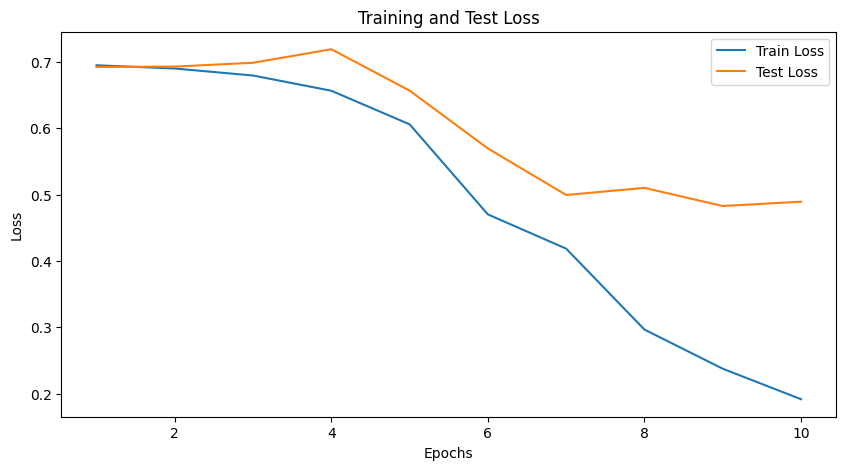

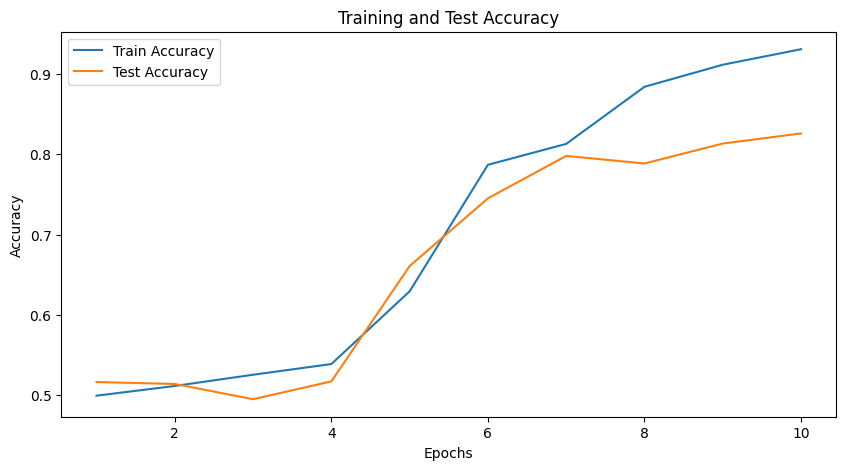

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word_to_index, max_length):
        self.reviews = reviews
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]

        # Tokenize and convert words to indices
        review_indices = [self.word_to_index[word] if word in self.word_to_index else 0 for word in review]
        # Pad or truncate the review to the max_length
        review_indices = review_indices[:self.max_length] + [0] * (self.max_length - len(review_indices))

        return torch.tensor(review_indices), torch.tensor(label)

def preprocess_text(reviews, use_stemming=False):
    if use_stemming:
        stemmer = PorterStemmer()
        preprocessed_reviews = [[stemmer.stem(token) for token in word_tokenize(review.lower())] for review in reviews]
    else:
        lemmatizer = WordNetLemmatizer()
        preprocessed_reviews = [[lemmatizer.lemmatize(token) for token in word_tokenize(review.lower())] for review in reviews]
    return preprocessed_reviews

def create_word_to_index(reviews):
    word_to_index = {}
    index = 1  # Start index from # Start index from 1, reserve index 0 for padding
    for review in reviews:
        for word in review:
            if word not in word_to_index:
                word_to_index[word] = index
                index += 1
    return word_to_index

# Step 2: Create Dataloaders

def create_dataloaders(reviews, labels, word_to_index, max_length, batch_size, split_ratio=0.2):
    dataset = IMDBDataset(reviews, labels, word_to_index, max_length)
    train_size = int((1 - split_ratio) * len(dataset))
    test_size = int(split_ratio * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Step 3: Define the LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_strategy='last_output'):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_strategy = rnn_strategy

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)

        if self.rnn_strategy == 'last_output':
            output = output[:, -1, :]  # Use the last output of the LSTM layer
        elif self.rnn_strategy == 'mean_of_all_outputs':
            output = output.mean(dim=1)  # Use the mean of all outputs of the LSTM layer

        output = self.fc(output)
        return output

# Step 4: Training and Testing Functions

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

# Step 5: Hyperparameters and Training Loop

def train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb=False):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, criterion, optimizer, train_loader, device)
        test_loss, test_accuracy = test_model(model, criterion, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

        if use_wandb:
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            })

    return train_losses, train_accuracies, test_losses, test_accuracies

# Step 6: Main Function

def load_imdb_dataset():
    # Load the IMDb dataset
    imdb_dataset = load_dataset("imdb")

    # Extract reviews and labels
    reviews = imdb_dataset["train"]["text"]
    labels = imdb_dataset["train"]["label"]

    return reviews, labels

def main():
    reviews, labels = load_imdb_dataset()
    # Define hyperparameters
    max_vocab_size = 10000  # Maximum vocabulary size
    hidden_size = 128
    output_size = 2  # Binary classification: positive or negative
    max_length = 500
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    # Preprocess and tokenize reviews
    reviews = preprocess_text(reviews)
    flat_reviews = [word for review in reviews for word in review]
    word_freq = nltk.FreqDist(flat_reviews)
    # Select the most common words up to the maximum vocabulary size
    vocab = {word for word, _ in word_freq.most_common(max_vocab_size)}
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve index 0 for padding

    # Create DataLoader
    train_loader, test_loader = create_dataloaders(reviews, labels, word_to_index, max_length, batch_size)

    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMModel(input_size=len(word_to_index) + 1, hidden_size=hidden_size, output_size=output_size).to(device)  # Add 1 for padding index
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize Weights & Biases if enabled
    use_wandb = True  # Set to True to enable logging with wandb
    if use_wandb:
        wandb.init(project="imdb_review_sentiment_classification", config={
            "max_vocab_size": max_vocab_size,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "max_length": max_length,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "use_stemming": True,  # Change to False if not using stemming
            "rnn_strategy": 'mean_of_all_outputs'  # Change to 'mean_of_all_outputs' to test different strategy
        })
        wandb.watch(model)

    # Training loop
    train_losses, train_accuracies, test_losses, test_accuracies = train_loop(train_loader, test_loader, model, criterion, optimizer, device, num_epochs, use_wandb)

    # Plot loss and accuracy graphs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()